In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
from pandas.tseries.offsets import MonthEnd
import pmp_functions_v5 as pmp



In [9]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    "../Data/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/37/zcyd0byn17lfrmxtt4_4k3s40000gn/T/ipykernel_81639/383609709.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,UMD,BAB,RMW,CMA
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,0.0745,-0.0056,-0.0184,0.0189
1980-02-29,-0.0123,-0.0162,0.0059,0.0789,0.0571,-0.0095,0.0292
1980-03-31,-0.1289,-0.0697,-0.0096,-0.0958,0.0605,0.0182,-0.0105
1980-04-30,0.0396,0.0105,0.0103,-0.0048,0.0145,-0.0218,0.0034
1980-05-31,0.0526,0.0200,0.0038,-0.0118,-0.0311,0.0043,-0.0063
...,...,...,...,...,...,...,...
2025-06-30,0.0486,-0.0002,-0.0160,-0.0264,-0.0246,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0096,-0.0842,-0.0029,-0.0208
2025-08-31,0.0185,0.0488,0.0442,-0.0354,0.0391,-0.0068,0.0207


In [10]:
## FUNDAMENTAL STRATEGY 
## --------------------
## This script implements a long/short fundamental strategy across regional equity indices.

# =============================================================================
# 0. CONFIGURATION
# =============================================================================
DATA_DIR = Path(r"../Data/")

FUND_FILE      = DATA_DIR / "Fundamental_Indicators.xlsx"
FX_FILE        = DATA_DIR / "FX.xlsx"  
PRICE_FILE     = DATA_DIR / "Futures.xlsx" 

# --- UPDATED FILES ---
RF_FILE        = DATA_DIR / "RF.csv"               # Changed to CSV
BENCHMARK_FILE = DATA_DIR / "Benchmarks.xlsx"       # Added Benchmark file

# Volatility target for the whole strategy (annualized)
TARGET_VOL_ANN = 0.10

# Transaction cost per unit of *turnover* TCOST_PER_UNIT = 0.000

SIGNAL_CONFIG = [
    {"ind": "ADJ_PE",              "lag": 6, "sign": -1}, 
    {"ind": "PX_TO_BOOK_RATIO",    "lag": 6, "sign": -1}, 
    {"ind": "IS_EPS",              "lag": 6, "sign":  1}, 
    {"ind": "PX_TO_SALES_RATIO",   "lag": 6, "sign": -1}, 
    {"ind": "RETURN_ON_ASSET",     "lag": 6, "sign":  1}, 
]

In [11]:
# =============================================================================
# 1. DATA LOADING FUNCTIONS
# =============================================================================

def load_fundamentals_dict(path: Path) -> dict:
    """
    Load panel of fundamental indicators and return it as a dict of DataFrames.
    """
    df = pd.read_excel(path)
    
    # Ensure Date is datetime and aligned to month end
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    # Convert wide columns to long format
    long = df.melt(id_vars="Date", var_name="raw_col", value_name="value").dropna(subset=["value"])
    
    # Split raw_col into Region & Indicator
    long[["Region", "Indicator"]] = long["raw_col"].str.split("_", n=1, expand=True)
    
    # Pivot into a multi-index columns DataFrame
    full_panel = long.pivot_table(
        index="Date",
        columns=["Indicator", "Region"],
        values="value",
        aggfunc="mean"
    )
    
    # Split into dict by Indicator
    fund_dict = {}
    unique_inds = full_panel.columns.get_level_values(0).unique()
    for ind in unique_inds:
        fund_dict[ind] = full_panel[ind].sort_index()
        
    return fund_dict


def load_prices_futures_usd(path: Path) -> pd.DataFrame:
    """
    Load equity futures prices (already in USD) and compute monthly returns.
    """
    df = pd.read_excel(path)
    df["Date"] = pd.to_datetime(df["Date"])
    
    if "UK" in df.columns:
        df = df.rename(columns={"UK": "GB"})

    df = df.set_index("Date").sort_index()
    
    # Monthly returns in USD
    ret_panel = df.pct_change()
    
    # Align index to month end
    ret_panel.index = ret_panel.index + MonthEnd(0)
    
    # Handle duplicates
    ret_panel = ret_panel.groupby(level=0).last()
    
    return ret_panel


def load_rf_csv(path: Path) -> pd.Series:
    """
    Load risk-free rate from CSV. 
    Format: Date, RF (returns)
    """
    df = pd.read_csv(path)
    
    # Parse dates and align to MonthEnd
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    df = df.set_index("Date").sort_index()
    
    # Return the RF column
    return df["RF"]


def load_benchmark(path: Path) -> pd.Series:
    """
    Load Benchmark Excel, select MSCI World, compute returns.
    """
    df = pd.read_excel(path)
    
    # Parse dates and align to MonthEnd
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    df = df.set_index("Date").sort_index()
    
    # Ensure we select MSCI World and calculate returns
    # Assuming column name is strictly "MSCI World"
    prices = df["MSCI World"]
    
    # Calculate returns
    returns = prices.pct_change()
    
    return returns

In [12]:
# =============================================================================
# 2. CALCULATION LOGIC (SIGNALS)
# =============================================================================
def compute_signals(fund_dict, returns_df, config):
    """
    Construct the composite fundamental signal and estimate rolling volatility.
    """
    # 1) Estimate rolling vol per region
    rolling_std = (
        returns_df
        .rolling(window=36, min_periods=36)
        .std()
        .replace(0, np.nan)
    )
    
    # 2) master_z will accumulate z-scores
    master_z = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    valid_count = 0 
    
    # 3) Loop over each configured indicator
    for cfg in config:
        ind  = cfg["ind"]
        lag  = cfg["lag"]
        sign = cfg["sign"] 
        
        if ind in fund_dict:
            panel = fund_dict[ind]   

            mom = panel.diff(lag) * sign

            mu    = mom.mean(axis=1)
            sigma = mom.std(axis=1)

            z = mom.sub(mu, axis=0).div(sigma, axis=0).fillna(0)
            master_z = master_z.add(z, fill_value=0)

            valid_count += 1
            
    final_signal = master_z / valid_count if valid_count > 0 else master_z

    return rolling_std, final_signal


In [13]:
# =============================================================================
# 3. PERFORMANCE SUMMARY (Helper)
# =============================================================================
# Note: summarizePerformance is a helper. The main summary is likely 
# run_perf_summary_benchmark_vs_strategy which is external or imported.

def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor=12, strategyNames=None):
    xsReturns        = np.array(xsReturns)
    factorXsReturns = np.array(factorXsReturns).flatten()
    
    metrics = []
    
    for i in range(xsReturns.shape[1]):
        r_xs = xsReturns[:, i] 
        
        mu = np.mean(r_xs) * annualizationFactor                   
        sig = np.std(r_xs, ddof=1) * np.sqrt(annualizationFactor)   
        sharpe = mu / sig if sig > 0 else 0
        
        if np.std(factorXsReturns) == 0 or np.std(r_xs) == 0:
            beta, alpha, corr = 0.0, 0.0, 0.0
        else:
            slope, intercept, r_value, _, _ = stats.linregress(factorXsReturns, r_xs)
            beta  = slope
            alpha = intercept * annualizationFactor 
            corr  = r_value
            
        metrics.append({
            "Ann. Return (XS)": mu,
            "Ann. Volatility":  sig,
            "Sharpe Ratio":     sharpe,
            "Beta":             beta,
            "Ann. Alpha":       alpha,
            "Correlation":      corr
        })
        
    df = pd.DataFrame(
        metrics,
        index=strategyNames if strategyNames else [f"Strat {i}" for i in range(len(metrics))]
    )
    return df.T

Loading Data...
Running Backtest (Unhedged Futures)...

--- PERFORMANCE SUMMARY (VS MSCI WORLD) ---
                         MSCI World  Fund L/S (Unhedged)
Arithm Avg Total Return      8.4420               6.4817
Arithm Avg Xs Return         6.7244               4.7641
Std Xs Returns              15.4575               8.8023
Sharpe Arithmetic            0.4350               0.5412
Geom Avg Total Return        7.4849               6.2757
Geom Avg Xs Return           5.7556               4.5464
Sharpe Geometric             0.3724               0.5165
Min Xs Return              -18.9340              -7.4827
Max Xs Return               12.8284              12.0927
Skewness                    -0.5990               0.7692
Excess Kurtosis              1.2827               2.2933
Alpha Arithmetic            -0.0000               4.8964
Alpha Arithmetic p-val       0.0001               0.0052
Alpha Geometric              0.0000               4.6813
Beta 1                       1.0000          

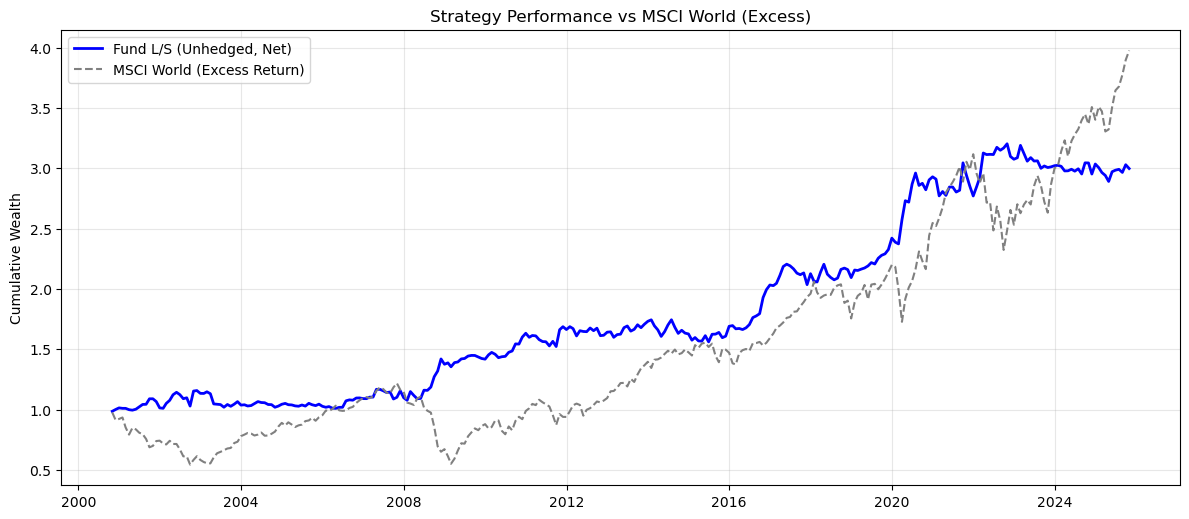

In [14]:
# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================

# A. Load Data
print("Loading Data...")
fund_dict         = load_fundamentals_dict(FUND_FILE)
ret_unhedged_usd  = load_prices_futures_usd(PRICE_FILE)

# --- UPDATED LOADING CALLS ---
rf_series         = load_rf_csv(RF_FILE)
benchmark_returns = load_benchmark(BENCHMARK_FILE)

# B. Calculate Signals
vol_usd, signal = compute_signals(fund_dict, ret_unhedged_usd, SIGNAL_CONFIG)

# C. Calculate Weights
vol_target_monthly = TARGET_VOL_ANN / np.sqrt(12)
risk_scaler = vol_target_monthly / vol_usd
raw_weights = signal * risk_scaler

# D. Prepare Data for Backtest Engine
final_weights = raw_weights.reindex(ret_unhedged_usd.index).fillna(0)

print("Running Backtest (Unhedged Futures)...")

perf_df = pmp.run_cc_strategy(
    weights      = final_weights,
    returns      = ret_unhedged_usd.dropna(how='all'), 
    rf           = rf_series,
    t_cost       = 0,
    benchmark    = benchmark_returns   # We run it with 'equal' initially, then overwrite below    
)

# --- CRITICAL ADJUSTMENT: OVERWRITE BENCHMARK ---
# The backtest creates a 'ret_bm' column (likely Equal Weight). 
# We overwrite it with MSCI World for the summary.

# 1. Align MSCI World returns to the backtest dates
aligned_msci = benchmark_returns.reindex(perf_df.index).fillna(0)

# 2. Inject into results DataFrame
perf_df["ret_bm"] = aligned_msci

# E. Plotting & Summary
perf_df = perf_df[perf_df["turnover"].cumsum() > 0]

cum_strat = (1 + perf_df["ret_net"]).cumprod()

# Calculate Excess Returns for Benchmark (MSCI World - RF) before plotting
bench_excess = perf_df["ret_bm"] - perf_df["ret_rf"]
cum_bench = (1 + bench_excess).cumprod()

print("\n--- PERFORMANCE SUMMARY (VS MSCI WORLD) ---")

# Now run the summary function. It will pick up the modified 'ret_bm' from perf_df
# NOTE: Assumes run_perf_summary_benchmark_vs_strategy is defined in your environment
summary_table = pmp.run_perf_summary_benchmark_vs_strategy(
    results=perf_df,
    alreadyXs=True, 
    annualizationFactor=12,
    strategyNames=["MSCI World", "Fund L/S (Unhedged)"] # Updated Label
)
print(summary_table)

# --- DETAILED MONTHLY RETURNS & WEIGHTS ---
print("\n--- DETAILED MONTHLY RETURNS & WEIGHTS ---")
cols_to_show = ["ret_net", "ret_gross", "ret_rf", "ret_bm"] + [
    c for c in perf_df.columns if c.startswith("w_")
]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(perf_df[cols_to_show])

# --------------------------------------------------
# Plot performance & weights
plt.figure(figsize=(12, 10))

# Plot 1: Cumulative wealth 
plt.subplot(2, 1, 1)
plt.plot(cum_strat.index, cum_strat, label="Fund L/S (Unhedged, Net)", color='blue', linewidth=2)
plt.plot(cum_bench.index, cum_bench, label="MSCI World (Excess Return)", color='gray', linestyle="--") # Updated Label
plt.title("Strategy Performance vs MSCI World (Excess)")
plt.ylabel("Cumulative Wealth")
plt.legend()
plt.grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [15]:
pmp.run_factor_regression(perf_df, famafrench_data, alreadyXs=True)

,Strategy
Arithm Avg Total Return,6.4817
Arithm Avg Xs Return,4.7641
Std Xs Returns,8.8023
Sharpe Arithmetic,0.5412
Geom Avg Total Return,6.2757
Geom Avg Xs Return,4.5464
Sharpe Geometric,0.5165
Min Xs Return,-7.4827
Max Xs Return,12.0927
Skewness,0.7692
